In [ ]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

image_all = mpimg.imread("todo.png",True)
_ = plt.figure(figsize=(40,80))
_ = plt.imshow(image_all, cmap='gray')


In [ ]:
# convetimos la imagen a blanco y negro (1bit)
intensity_thres = 70
image_bw = (image_all>intensity_thres)

#### Busqueda de puntos de corte horizontales y verticales
Para ello se suma la imagen en vertical y en horizontal. Donde están las rayas negras son mínimos. Se detectan esos mínimos para cortar

In [ ]:
# Suma de la imagen en blanco y negro para detectar las rayas horizontales
horizontal = image_bw.sum(1)
thrsH = 500

n = 5000
_ = plt.figure(figsize=(20,10))
_ = plt.plot(range(n), horizontal[0:n], range(n), [thrsH]*n)


In [ ]:
# Suma de la imagen en blanco y negro para detectar las rayas horizontales

vertical = image_bw.sum(0)
thrsV = 5000
n = len(vertical)
_ = plt.plot(range(n), vertical, range(n), [thrsV]*n)

In [ ]:
# Cortes
def cortes(valores, umbral, crop=15):
    """ A partir de un vector de valores y un umbral busca 
        donde la curva sube y luego baja. Entre medias esta
        la imagen que buscamos. Luego reduce los valores 
        encontrados con 'crop' para no seleccionar las rayas 
        negras"""
    zonas_picos = valores>umbral
    cuts = []
    i1 = 0
    while True:
        if i1 >= len(zonas_picos)-1:
            break
        if zonas_picos[i1] == False and zonas_picos[i1+1] == True:
            for i2 in range(i1+1, len(zonas_picos)-1):
                if zonas_picos[i2] == True and zonas_picos[i2+1] == False:
                    cuts.append((i1+crop, i2-crop))
                    i1 = i2
                    break
                    
        i1 = i1 + 1

    return list(cuts)

cutsH = cortes(horizontal, thrsH, 21)
cutsV = cortes(vertical, thrsV, 15)
print("Se han encontrado {0} filas y {1} columnas".format(len(cutsH), len(cutsV)))

In [ ]:

class Numerito:                                                               
    def __init__(self, ancho, alto):
        self.clase = -1
        self.imagen = np.full((int(ancho),int(alto)), 0)
        

#cutsH = np.linspace(51,57310,121)
#cutsH = [(int(round(v1)),int(round(v2))) for v1,v2 in zip(np.linspace(56,57315,121), np.linspace(451,57710,121))]


In [ ]:
from scipy import misc

# Corta las imágenes de los números y las guarda las imágenes
# También se guardan en la lista 'numeritos'

# Calculamos los máximos de ancho y alto para guardar todas las 
# imágenes de un mismo tamaño
w = max(map(lambda c:c[1]-c[0],cutsV))
h = max(map(lambda c:c[1]-c[0],cutsH))
w = w+1 if w%2==1 else w
h = h+1 if h%2==1 else h
ww = w
hh = h

i = 0
numeritos = []
for ch in cutsH:
    for cv in cutsV:
        num = Numerito(hh, ww)
        
        # Extraemos la imagen y se pega en el centro de la imagen de num
        im = image_all[ch[0]:ch[1],cv[0]:cv[1]]
        dy,dx = im.shape[0]/2,im.shape[1]/2 
        num.imagen[int(round(hh/2-dy)):int(round(hh/2-dy)+(ch[1]-ch[0])),
                   int(round(ww/2-dx)):int(round(ww/2-dx)+(cv[1]-cv[0]))] = im
        
        num.clase = i % 10
        
        numeritos.append(num)
 
        misc.toimage(num.imagen).save('nums/i%05d.png' % (i))
    
        i += 1
        

In [ ]:
     
# Se saca por pantalla una muestra de las imágenes
plt.figure(figsize=(10,10))
for i,iimg in enumerate(np.random.randint(0,len(numeritos), size=100)):
    plt.subplot(10,10,i+1)
    plt.imshow(numeritos[iimg].imagen)
        

In [ ]:
from skimage.feature import corner_harris
from skimage.morphology import skeletonize
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter
from skimage import data, color
from skimage.filters import median


gray = numeritos[1].imagen
gray = median(gray)
th = 100
gray[gray>th] = 255
gray[gray<=th] = 0
edges = canny(gray, sigma=3, low_threshold=10, high_threshold=50)

nivel = sum(sum(gray))

hough_radii = np.arange(70, 150, 2)
hough_res = hough_circle(edges, hough_radii)

# Select the most prominent 5 circles
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,
                                           total_num_peaks=1)


gray = np.float32(gray)
dst = corner_harris(gray/255)


plt.figure()
image = color.gray2rgb(gray)
for center_y, center_x, radius in zip(cy, cx, radii):
    circy, circx = circle_perimeter(center_y, center_x, radius)
    image[circy, circx] = (220, 20, 20)

plt.imshow(image, cmap=plt.cm.gray)


#result is dilated for marking the corners, not important

# Threshold for an optimal value, it may vary depending on the image.
#gray[dst>0.01*dst.max()] = 0
plt.figure()
plt.imshow(gray)
plt.figure()
plt.imshow(skeletonize(1-gray/255))
nivel

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data, color
from skimage.transform import hough_circle
from skimage.feature import peak_local_max, canny
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte
from skimage.io import imread


# Load picture and detect edges
image = 255 - gray
edges = canny(image, sigma=3, low_threshold=10, high_threshold=50)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(20, 10))

# Detect two radii
hough_radii = np.arange(13, 15, 2)
hough_res = hough_circle(edges, hough_radii)

centers = []
accums = []
radii = []

for radius, h in zip(hough_radii, hough_res):
    # For each radius, extract 5 circles
    num_peaks = 5
    peaks = peak_local_max(h, num_peaks=num_peaks)
    centers.extend(peaks)
    accums.extend(h[peaks[:, 0], peaks[:, 1]])
    radii.extend([radius] * num_peaks)

# Draw the most prominent 5 circles
image = color.gray2rgb(image)
for idx in np.argsort(accums)[::-1][:]:
    center_x, center_y = centers[idx]
    radius = radii[idx]
    cx, cy = circle_perimeter(center_y, center_x, radius)
    image[cy, cx] = (220, 20, 20)

ax.imshow(image, cmap=plt.cm.gray)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.transform import hough_line
from skimage.draw import line

img = gray

out, angles, d = hough_line(img)

fix, axes = plt.subplots(1, 2, figsize=(7, 4))

axes[0].imshow(img, cmap=plt.cm.gray)
axes[0].set_title('Input image')

axes[1].imshow(
    out, cmap=plt.cm.bone,
    extent=(np.rad2deg(angles[-1]), np.rad2deg(angles[0]), d[-1], d[0]))
axes[1].set_title('Hough transform')
axes[1].set_xlabel('Angle (degree)')
axes[1].set_ylabel('Distance (pixel)')

plt.tight_layout()
plt.show()

In [9]:
import numpy as np

from skimage.transform import hough_line, hough_line_peaks,
                               probabilistic_hough_line
from skimage.feature import canny
from skimage import data
from skimage.morphology import skeletonize, skeletonize_3d
import matplotlib.pyplot as plt
from matplotlib import cm
from skimage.morphology import disk

th = 120
gray = numeritos[8].imagen
gray = median(gray, disk(7))
gray[gray>th] = 255
gray[gray<=th] = 0
plt.figure()
plt.imshow(gray)

# Constructing test image
image = skeletonize_3d((255-gray)/255)
image[:30, :] = 0;
image[-30:, :] = 0;
image[:, :30] = 0;
image[:, -30:] = 0;
plt.figure()
plt.imshow(image)

# Classic straight-line Hough transform
h, theta, d = hough_line(image)

# Generating figure 1
fig, axes = plt.subplots(1, 3, figsize=(15, 6),
                         subplot_kw={'adjustable': 'box-forced'})
ax = axes.ravel()

ax[0].imshow(image, cmap=cm.gray)
ax[0].set_title('Input image')
ax[0].set_axis_off()

ax[1].imshow(np.log(1 + h),
             extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]), d[-1], d[0]],
             cmap=cm.gray, aspect=1/1.5)

ax[1].set_title('Hough transform')
ax[1].set_xlabel('Angles (degrees)')
ax[1].set_ylabel('Distance (pixels)')
ax[1].axis('image')

ax[2].imshow(image, cmap=cm.gray)

for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - image.shape[1] * np.cos(angle)) / np.sin(angle)
    ax[2].plot((0, image.shape[1]), (y0, y1), '-r')
    
ax[2].set_xlim((0, image.shape[1]))
ax[2].set_ylim((image.shape[0], 0))
ax[2].set_axis_off()
ax[2].set_title('Detected lines')

plt.tight_layout()
plt.show()


IndentationError: unexpected indent (<ipython-input-9-b5e81c0c7bf8>, line 4)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
0


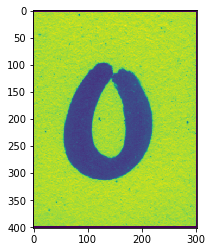

intensidad_media: 190.362096801


In [12]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import proceso_imagenes
import matplotlib.pyplot as plt

imagenes, clases = proceso_imagenes.cargar_numeros("./nums")

imagen = imagenes[-1]






5


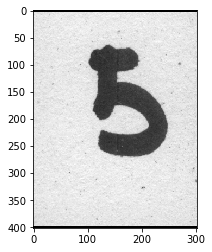

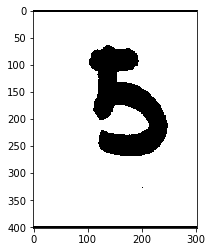

/opt/anaconda3-4.4.0/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


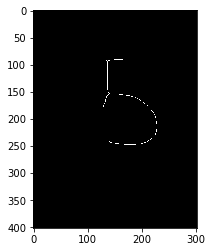

intensidad_media: 204.508162828
intensidad_media_umbral: 218.421098152
rectas: 6


In [40]:
indice = 7

print(clases[indice])
imagen = imagenes[indice]

plt.figure()
plt.imshow(imagen, cmap='gray')
plt.show()
plt.close()

plt.figure()
plt.imshow(proceso_imagenes.umbralizar_imagen(imagen), cmap='gray')
plt.show()
plt.close()


plt.figure()
plt.imshow(proceso_imagenes.obtener_esqueleto(imagen), cmap='gray')
plt.show()
plt.close()

print("intensidad_media:",proceso_imagenes.intensidad_media(imagen))
print("intensidad_media_umbral:",proceso_imagenes.intensidad_media_umbralizada(imagen))
print("rectas:",proceso_imagenes.contar_rectas(imagen))

In [8]:
import numpy as np
a = np.ones(10).reshape(2,5)
np.sum(a)

10.0